**线性神经网络**

@ Follow: "动手学深度学习-第三章 线性神经网络"

In [64]:
import time
import random
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from d2l import torch as d2l

---
# 小实验: 向量化带来的速度提升

In [65]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

class Timer:
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        self.tik = time.time()

    def stop(self):
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    def avg(self):
        return sum(self.times) / len(self.times)
    def sum(self):
        return sum(self.times)

In [66]:
# 方法1: 使用for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'for loop:{timer.stop():.5f} sec')

# 方法2: 使用向量化
timer.start()
d = a + b
print(f'vectorization:{timer.stop():.5f} sec')

for loop:0.02554 sec
vectorization:0.00008 sec


---
# 线性回归-从0开始
- 线性模型满足线性假设
- 线性假设: 预测目标可以表示为输入特征的线性求和, 并加上一个偏置
- 数学形式: $ \hat{y} = Xw + b$
- 线性回归的目标: 找到一组权重向量$w$和偏置b(统称为模型参数)
- Mean Squared Error(MSE): 均方误差
    - 形式: $l(i) = \frac{1}{2} (\hat{y}^{(i)} - y^{(i)})^2$
    - 如果噪声服从正态分布, 优化MSE等价于优化最大似然(-log[likelihood])
- 取-log的原因: 使得优化是朝着最小值方向
- 线性模型是最简单的神经网络
- 由于模型重点发生在计算的地方, 计算神经网络的层数时, 不包括输入层

## 生成模拟数据集

In [67]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成num_examples行，len(w)列的正态分布矩阵
    y = torch.matmul(X, w) + b  # 构造模拟数据
    y += torch.normal(0, 0.01, y.shape)  # 添加噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.2683,  0.3934]) 
label: tensor([2.3264])


In [68]:
features.detach()

tensor([[-0.2683,  0.3934],
        [-1.1144,  2.8376],
        [-0.4211, -1.3855],
        ...,
        [-1.8178, -1.4703],
        [ 0.0626,  0.7391],
        [ 0.4925,  0.5973]])

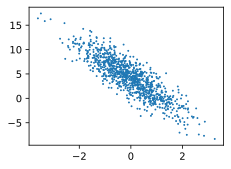

In [69]:
# 观察到特征和标签之间的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

## 小批量读取数据

In [70]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [71]:
batch_size = 9
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0560,  0.8352],
        [-0.0907, -1.4074],
        [ 0.2685,  2.2375],
        [-1.3834, -1.9798],
        [-0.2854,  1.6663],
        [ 0.0863, -0.9720],
        [-0.7552, -0.8972],
        [ 1.5740, -0.6253],
        [-0.0699,  1.5007]]) 
 tensor([[ 1.4720],
        [ 8.7999],
        [-2.8557],
        [ 8.1609],
        [-2.0367],
        [ 7.6838],
        [ 5.7450],
        [ 9.4658],
        [-1.0427]])


## 定义模型、损失函数、优化算法

In [72]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """均方误差"""
    return 0.5 *(y_hat - y.reshape(y_hat.shape))**2

def sgd(params, lr, batch_size):
    """
    Minibatch stochastic gradient descent.

    :params: A list of parameters to optimize.
    :lr: The learning rate.
    :batch_size: The number of examples in each minibatch.
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练模型

In [73]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(f"w:{w}\nb:{b}")

# 超参数
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

w:tensor([[ 0.0162],
        [-0.0147]], requires_grad=True)
b:tensor([0.], requires_grad=True)
epoch 1, loss 0.018754
epoch 2, loss 0.000079
epoch 3, loss 0.000053
epoch 4, loss 0.000053
epoch 5, loss 0.000053


## 模型评估

In [74]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0008, -0.0007], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0003], grad_fn=<RsubBackward1>)


---
# 线形回归-简洁实现

## 生成数据集

In [75]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [76]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 打印第一个小批量样本
next(iter(data_iter))

[tensor([[-0.2732,  0.1855],
         [-0.8263, -0.4296],
         [-0.2121,  0.9243],
         [ 1.7240,  1.9573],
         [ 0.7762, -1.1661],
         [ 0.0106,  0.3836],
         [ 0.0694,  0.5202],
         [ 1.8481,  0.1009],
         [ 1.9417, -1.2230],
         [ 0.0094,  1.0101]]),
 tensor([[ 3.0263],
         [ 4.0145],
         [ 0.6238],
         [ 0.9843],
         [ 9.7275],
         [ 2.9235],
         [ 2.5731],
         [ 7.5754],
         [12.2210],
         [ 0.7774]])]

## 定义模型

In [77]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 定义损失函数

In [78]:
loss = nn.MSELoss()

## 定义优化算法

In [79]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 训练模型

In [80]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()  # 梯度清零
        l.backward()  # 计算梯度
        trainer.step()  # 更新模型参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000246
epoch 2, loss 0.000094
epoch 3, loss 0.000093
epoch 4, loss 0.000093
epoch 5, loss 0.000093


## 读取结果

In [81]:
w = net[0].weight.data
print('w的估计误差:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差:', true_b - b)

w的估计误差: tensor([ 0.0008, -0.0003])
b的估计误差: tensor([-3.2902e-05])


---
# softmax回归 - 从0开始
- one-hot encoding (独热编码):
    1. 将类别标签转换为向量, 每个类别对应一个唯一的索引, 该索引在向量中对应的位置为1, 其他位置为0
    2. 例如, 对于一个三分类问题, 类别标签为{0, 1, 2}, 则独热编码为[1, 0, 0], [0, 1, 0], [0, 0, 1]
    3. 独热编码避免了类别之间无意义的顺序关系
- softmax运算:
    1. 在分类任务中, 模型的输出值是任意的, softmax运算用于将分类模型的输出值转换成预测概率
    2. 形式: $\hat{y} = \text{softmax}(o)$, 其中$o$是模型的输出值, $\hat{y}$是预测概率
    3. 函数: $\hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$
    4. 通过指数函数, 将输出值转换成非负数; 通过除以所有输出值之和, 确保转换后的值之和为1
    5. softmax函数的导数是softmax模型分配的概率与实际发生的概率的差异$$\partial_{o_j} l(y, \hat{y}) = \text{softmax}(o)_j - y_j$$
- 信息量(Information Content):
    1. 对于一个离散随机变量X, 可能的取值为$x_1, x_2, ..., x_n$, 对应的概率为$p_1, p_2, ..., p_n$, 则信息量定义为$I(x) = -\log p(x)$
    2. 一个确定时间的概率为1, 其信息量为0; 一个低概率事件的信息量较大
- 熵(entropy):
    1. 定义: 对于一个离散随机变量X, 可能的取值为$x_1, x_2, ..., x_n$, 对应的概率为$p_1, p_2, ..., p_n$, 则熵定义为$H(X) = -\sum_{i=1}^n p_i \log p_i$
    2. $H(x)$的单位: 若log以2为底, 则单位为比特(bit); 若log以e为底, 则单位为奈特(nat)
    3. 确定事件的熵为0, 等概率事件的熵最大
    4. 信息量和熵的却别: 信息量是针对单个事件的, 熵是针对整个系统的平均信息量
    5. 熵是数据压缩的理论极限
- 交叉熵损失函数(Cross-Entropy Loss):
    1. 交叉熵: 量化两个概率分布的差异
    2. 定义: 有两个概率分布P和Q, 则交叉熵定义为$H(P, Q) = -\sum_{i=1}^n p_i \log q_i$
    3. P和Q的差异越大, 交叉熵越大; P和Q的差异越小, 交叉熵越小; P和Q相等时, 交叉熵最小
    4. 在机器学习中, 真实类别$y$和预测类别$\hat{y}$的交叉熵定义为$l(y, \hat{y}) = -\sum_{i=1}^n y_i \log \hat{y}_i$

## 数据加载

In [82]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

dir_data = Path("/Users/rui/Code/Astronote/32_PyTorch/data/chapter3")

trans = transforms.ToTensor()

# 加载数据集
d2l.use_svg_display()

In [83]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root=dir_data, train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(root=dir_data, train=False, transform=trans, download=False)

print(len(mnist_train), len(mnist_test))

60000 10000


In [84]:
mnist_train[0][0].shape  # 每个样本是一个28*28的灰度图像

torch.Size([1, 28, 28])

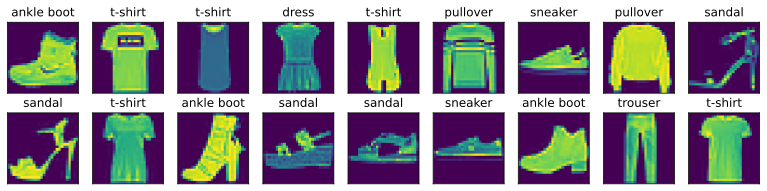

In [85]:
# 类别编码
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 可视化
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [86]:
# 读取小批量
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = torch.utils.data.DataLoader(
    mnist_train, batch_size, shuffle=True, 
    num_workers=get_dataloader_workers())

# 测试读取训练数据的时间
timer = d2l.Timer()
for X, y in train_iter:
    continue
print(f'{timer.stop():.2f} sec')

1.22 sec


In [87]:
# 整合上述代码

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=dir_data, train=True, 
                                                    transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root=dir_data, train=False, 
                                                   transform=trans, download=False)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, 
                                        num_workers=get_dataloader_workers()),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False, 
                                        num_workers=get_dataloader_workers()))

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
print(len(train_iter), len(test_iter))

235 40


## 初始化模型参数

In [88]:
num_inputs = 784  # 28*28
num_outputs = 10

# 初始化模型参数
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax函数

In [89]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [90]:
# 检查softmax函数
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1842, 0.3898, 0.1920, 0.1382, 0.0957],
         [0.0286, 0.2110, 0.0885, 0.0910, 0.5808]]),
 tensor([1.0000, 1.0000]))

## 定义模型

In [91]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

## 定义损失函数
- 交叉熵损失函数: $L = - \sum_{k=1}^C y_k \log(\hat{y}_k)$
- 对于one-hot编码的y, 交叉熵损失函数可简化为: $L = -\log(\hat{y}_t)$

In [92]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

# 检验
y = torch.tensor([0, 2])  # 两个样本的标签
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y, y_hat, y_hat[range(len(y_hat)), y], cross_entropy(y_hat, y)

(tensor([0, 2]),
 tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([0.1000, 0.5000]),
 tensor([2.3026, 0.6931]))

## 模型评价指标: 分类精度

In [93]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [94]:
class Accumulator:
    """在`n`个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

metric = Accumulator(2)  # 创建 2 个累加变量
metric.add(5, 10)        # metric.data = [5, 10]
metric.add(3, 4)         # metric.data = [8, 14]
print(metric[0])  # 输出 8
print(metric[1])  # 输出 14

8.0
14.0


In [95]:
metric.data

[8.0, 14.0]

In [96]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)

0.1217

## 训练

In [97]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期(定义见第3章)"""
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [98]:
from IPython import display

class Animator:
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(5, 3)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [99]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型(定义见第3章)"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [100]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

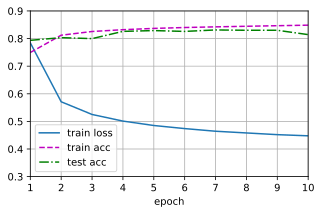

In [101]:
num_epochs = 10

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 预测

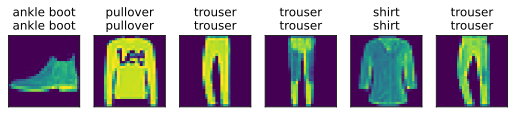

In [104]:
def predict_ch3(net, test_iter, n=6):
    """预测标签(定义见第3章)"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

---
# Softmax回归的简洁实现

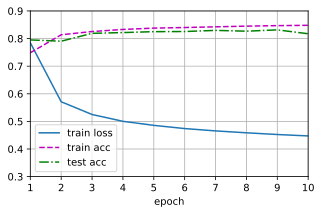

In [107]:
# 加载数据
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# 定义网络
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

# 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 训练
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)